# 🕸️ GAT: Kogo słuchać w tłumie? (Graph Attention Networks)

Zwykły GCN to "demokracja" (każdy sąsiad ma 1 głos).
GAT to "merytokracja" (głosują tylko ważni).

**Mechanizm:**
Dla każdej krawędzi (relacji) między węzłem $i$ a węzłem $j$ liczmy **Współczynnik Uwagi** $\alpha_{ij}$:
1.  Bierzemy cechy obu węzłów ($h_i, h_j$).
2.  Sklejamy je i przepuszczamy przez małą sieć neuronową (Attention Mechanism $a$).
3.  Wynik normalizujemy Softmaxem (żeby suma uwag dla jednego węzła wynosiła 1).

$$ \alpha_{ij} = \text{Softmax}(\text{LeakyReLU}(a^T [Wh_i || Wh_j])) $$

**Klucz:** W GAT macierz sąsiedztwa służy tylko jako **Maska**. Liczymy uwagę tylko dla tych, z którymi jesteśmy połączeni (reszta to $-\infty$).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Tworzymy prosty graf (Gwiazda)
# Węzeł 0 (Centrum) jest połączony z 1, 2, 3, 4
adj_matrix = torch.tensor([
    [1, 1, 1, 1, 1], # 0 zna wszystkich (i siebie)
    [1, 1, 0, 0, 0], # 1 zna 0
    [1, 0, 1, 0, 0], # 2 zna 0
    [1, 0, 0, 1, 0], # 3 zna 0
    [1, 0, 0, 0, 1]  # 4 zna 0
], dtype=torch.float32).to(DEVICE)

# Cechy węzłów (Feature Matrix)
# Węzeł 0: [0, 0] (Neutralny)
# Węzeł 1: [1, 1] (Pozytywny)
# Węzeł 2: [-1,-1] (Negatywny)
# Reszta: Szum
X = torch.tensor([
    [0.0, 0.0],
    [1.0, 1.0],
    [-1.0, -1.0],
    [0.1, 0.2],
    [-0.1, -0.2]
], dtype=torch.float32).to(DEVICE)

print("Graf i cechy gotowe.")

Graf i cechy gotowe.


## Implementacja Warstwy GAT

To jest najtrudniejszy matematycznie moment. Musimy policzyć uwagę "każdy z każdym", ale tylko tam, gdzie istnieje krawędź.

**Triki tensorowe:**
1.  **Broadcasting:** Tworzymy macierz `[N, N, 2*F]`, gdzie w każdej komórce $(i, j)$ jest sklejony wektor węzła $i$ i $j$.
2.  **Maskowanie:** Tam, gdzie w macierzy sąsiedztwa jest 0, wstawiamy bardzo małą liczbę (np. -1e9). Softmax zamieni to na 0.

In [2]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # 1. Transformacja liniowa (W)
        self.W = nn.Linear(in_features, out_features, bias=False)
        
        # 2. Wektor atencji (a)
        # Przyjmuje sklejone cechy (2 * out_features) i zwraca 1 liczbę (score)
        self.a = nn.Linear(2 * out_features, 1, bias=False)
        
        self.leakyrelu = nn.LeakyReLU(0.2)

    def forward(self, x, adj):
        N = x.shape[0]
        
        # Krok 1: Transformacja cech (h = Wx)
        h = self.W(x) # [N, out_features]
        
        # Krok 2: Przygotowanie par (Concatenation)
        # Chcemy stworzyć macierz [N, N, 2*out], gdzie element (i,j) to [h_i || h_j]
        
        # h.repeat -> powiela wiersze
        h_repeated_in_chunks = h.view(N, 1, self.out_features).repeat(1, N, 1)      # [N, N, F] (i-ty wiersz to h_i)
        h_repeated_alternating = h.view(1, N, self.out_features).repeat(N, 1, 1)    # [N, N, F] (j-ta kolumna to h_j)
        
        # Sklejamy
        all_combinations = torch.cat([h_repeated_in_chunks, h_repeated_alternating], dim=2) # [N, N, 2F]
        
        # Krok 3: Obliczenie surowych punktów uwagi (e_ij)
        e = self.leakyrelu(self.a(all_combinations).squeeze(2)) # [N, N]
        
        # Krok 4: MASKOWANIE (Kluczowe dla Grafów!)
        # Tam gdzie nie ma krawędzi (adj=0), wstawiamy -nieskończoność
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        # Krok 5: Softmax (Normalizacja) -> Alpha_ij
        attention = F.softmax(attention, dim=1)
        
        # Krok 6: Agregacja (Ważona suma sąsiadów)
        # h_new = sum(alpha_ij * h_j)
        h_prime = torch.matmul(attention, h)
        
        return h_prime, attention

# Inicjalizacja
gat = GATLayer(in_features=2, out_features=2).to(DEVICE)
print("Warstwa GAT gotowa.")

Warstwa GAT gotowa.


## Symulacja "Inteligencji"

Ponieważ nie trenujemy tu sieci na wielkim zbiorze, **wymusimy wagi ręcznie**, żeby zobaczyć efekt.

Ustawimy wagi tak, żeby sieć "lubiła" węzły o wartościach dodatnich, a "nienawidziła" ujemnych.
Węzeł 0 (Centrum) powinien wtedy zignorować Węzeł 2 (Negatywny) i słuchać Węzła 1 (Pozytywny).

In [3]:
# HACK: Ręczne ustawienie wag, żeby zasymulować wytrenowany model
with torch.no_grad():
    # Transformacja W to Identity (nie zmienia cech)
    gat.W.weight.copy_(torch.eye(2))
    
    # Wektor uwagi 'a'.
    # [1, 1, 1, 1] oznacza: sumuj wszystkie cechy.
    # Ponieważ Węzeł 2 ma cechy [-1, -1], to suma będzie ujemna -> LeakyReLU da mały wynik.
    # Węzeł 1 ma [1, 1], suma dodatnia -> LeakyReLU da duży wynik.
    gat.a.weight.fill_(1.0)

# Uruchomienie
output_features, attn_weights = gat(X, adj_matrix)

print("--- CECHY PO GAT (Dla Węzła 0) ---")
print(f"Oryginał: {X[0].tolist()}")
print(f"Nowe:     {output_features[0].tolist()}")
print("(Powinny być przesunięte w stronę dodatnią, bo Węzeł 1 'przekrzyczał' Węzeł 2)")

--- CECHY PO GAT (Dla Węzła 0) ---
Oryginał: [0.0, 0.0]
Nowe:     [0.5955022573471069, 0.599097490310669]
(Powinny być przesunięte w stronę dodatnią, bo Węzeł 1 'przekrzyczał' Węzeł 2)


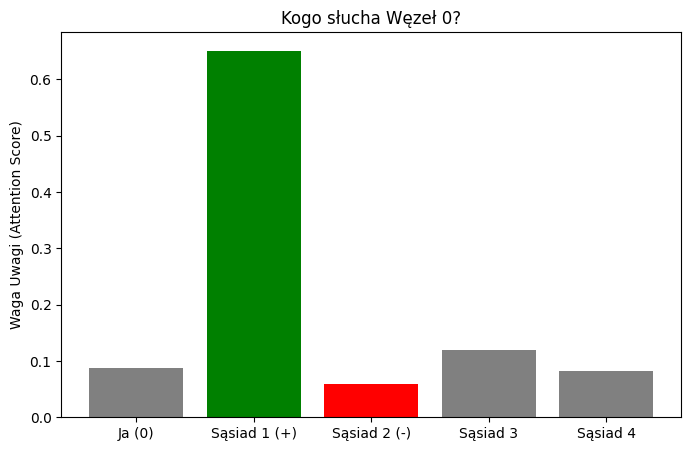

ANALIZA:
Waga dla Sąsiada 1 (Pozytywny): 0.6510
Waga dla Sąsiada 2 (Negatywny): 0.0591
✅ SUKCES! GAT nauczył się ignorować 'toksycznego' sąsiada.


In [4]:
# WIZUALIZACJA UWAGI
# Zobaczmy, kogo słucha Węzeł 0 (Centrum)

attn_row_0 = attn_weights[0, :].detach().cpu().numpy()

plt.figure(figsize=(8, 5))
plt.bar(range(5), attn_row_0, color=['gray', 'green', 'red', 'gray', 'gray'])
plt.xticks(range(5), ["Ja (0)", "Sąsiad 1 (+)", "Sąsiad 2 (-)", "Sąsiad 3", "Sąsiad 4"])
plt.ylabel("Waga Uwagi (Attention Score)")
plt.title("Kogo słucha Węzeł 0?")
plt.show()

print("ANALIZA:")
print(f"Waga dla Sąsiada 1 (Pozytywny): {attn_row_0[1]:.4f}")
print(f"Waga dla Sąsiada 2 (Negatywny): {attn_row_0[2]:.4f}")

if attn_row_0[1] > attn_row_0[2]:
    print("✅ SUKCES! GAT nauczył się ignorować 'toksycznego' sąsiada.")

## 🧠 Podsumowanie: GAT vs GCN

W zwykłym GCN (notatnik 58) słupki na wykresie byłyby **równe** (po 0.2 dla każdego z 5 węzłów).
W GAT sieć dynamicznie zmienia te słupki.

**Zastosowania:**
1.  **Social Media (Fake News):** GAT może nauczyć się ignorować boty (węzły o podejrzanych cechach), nawet jeśli są połączone z prawdziwymi ludźmi.
2.  **Chemia:** W cząsteczce niektóre wiązania (np. Podwójne) są ważniejsze dla właściwości chemicznych niż inne. GAT to wyłapuje.
3.  **Rekomendacje:** Nie każdy znajomy ma taki sam gust filmowy jak Ty. GAT waży wpływ znajomych na Twoje rekomendacje.